### Instructor Demo: Probable Outcomes of Stock Price Trajectory

This program executes `1000` simulations of stock price trajectory over the next `252` trading days (or year of trading), based on a normal probability distribution of average daily returns derived from the sample mean and standard deviation.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi

%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NASDAQ',
     'id': 'bb05f61a-daf9-4fff-9e26-e0adaf23fbb0',
     'marginable': True,
     'name': 'HBT Financial, Inc. Common Stock',
     'shortable': True,
     'status': 'active',
     'symbol': 'HBT',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'ARCA',
     'id': '38b93a03-cd62-4158-acfc-78b0ef46da46',
     'marginable': True,
     'name': 'Franklin FTSE Hong Kong ETF',
     'shortable': False,
     'status': 'active',
     'symbol': 'FLHK',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': 'd3f264d8-99ca-4261-8a0b-98ef4534bcfd',
     'marginable': True,
     'name': 'Hennessy Capital Acquisition Corp. IV Unit',
     'shortable': False,
     'status': 'active',
     'symbol': 'HCACU',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': Fals

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df["symbol"] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,HBT
1,FLHK
2,HCACU
3,HCAP
4,HCC
5,HCCHR
6,ARB
7,AXP
8,DEO
9,DSS


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [5]:
# Set the ticker
ticker = "AAPL"

# Set timeframe to "1D"
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2019-05-04", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-05-04", tz="America/New_York").isoformat()

# Get 1 year"s worth of historical data for AAPL
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

AAPL                                     
                              open      high      low   close    volume
2019-05-06 00:00:00-04:00  204.290  208.8400  203.500  208.60  28949691
2019-05-07 00:00:00-04:00  205.880  207.4175  200.825  202.86  34328425
2019-05-08 00:00:00-04:00  201.900  205.3400  201.750  202.90  22729670
2019-05-09 00:00:00-04:00  200.400  201.6800  196.660  200.72  32427147
2019-05-10 00:00:00-04:00  197.419  198.8500  192.770  197.30  36118438

### Drop Extraneous Columns

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=["open", "high", "low", "volume"], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.head()

,close
2019-05-06,208.60
2019-05-07,202.86
2019-05-08,202.90
2019-05-09,200.72
2019-05-10,197.30


### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of AAPL
daily_returns = df.pct_change()
daily_returns.head()

,close
2019-05-06,NaN
2019-05-07,-0.027517
2019-05-08,0.000197
2019-05-09,-0.010744
2019-05-10,-0.017039


### Calculate Value of Average Daily Returns

In [8]:
# Use the `mean` function to calculate the mean of daily returns for AAPL
avg_daily_return = daily_returns.mean()["close"]
avg_daily_return

0.001693341594111356

### Calculate Value of Standard Deviation of Daily Returns

In [9]:
# Use the `std` function to calculate the standard deviation of daily returns for AAPL
std_dev_daily_return = daily_returns.std()["close"]
std_dev_daily_return

0.025944544825252065

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [10]:
# Set number of simulations, trading days, and get last closing price of AAPL from DataFrame
num_simulations = 1000
num_trading_days = 252
aapl_last_price = df["close"][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of AAPL
    simulated_aapl_prices = [aapl_last_price]
    
    # Simulate the returns for 252 days
    for i in range(num_trading_days):
        # Calculate the simulated price using the last price within the list
        simulated_price = simulated_aapl_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
        # Append the simulated price to the list
        simulated_aapl_prices.append(simulated_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df[f"Simulation {n+1}"] = pd.Series(simulated_aapl_prices)

# Print head of DataFrame
simulated_price_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,293.170000,293.170000,293.170000,293.170000,293.170000,293.170000,293.170000,293.170000,293.170000,293.170000,...,293.170000,293.170000,293.170000,293.170000,293.170000,293.170000,293.170000,293.170000,293.170000,293.170000
1,297.391826,294.570059,281.266158,293.679989,298.408703,300.571167,284.612239,295.470413,293.731458,296.067571,...,298.691067,297.077834,300.820132,294.896179,282.980579,295.084411,292.426200,308.369553,281.883992,292.683188
2,307.933246,288.072729,280.048998,299.360689,287.979925,289.773230,269.646372,309.010268,288.440048,304.016873,...,309.381150,282.578434,310.328131,300.967140,268.356951,292.330219,300.827878,318.875707,286.402908,293.216108
3,315.284185,301.732583,288.056114,284.794566,282.449365,293.165693,274.485755,311.699859,276.039081,300.265051,...,296.603372,279.946887,310.832924,304.879392,275.578735,294.340151,288.920079,302.912529,279.935092,290.736585
4,313.883139,291.417894,290.588103,288.870714,277.724049,308.927097,273.904725,315.716285,283.226549,298.503327,...,290.817003,276.779889,316.933280,299.349232,275.732858,296.642250,286.970870,299.812492,284.843489,290.874400


### Plot the Multiple Simulations of Stock Price Trajectory for AAPL over the Next Year (252 Trading Days)

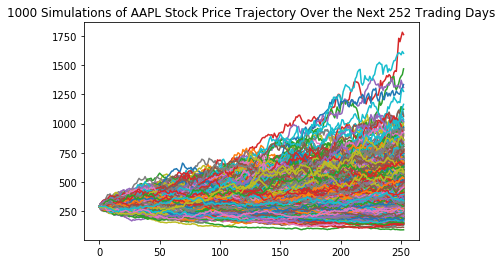

In [11]:
# Use the `plot` function to plot the trajectory of AAPL stock based on a 252 trading day simulation
plot_title = f"{n+1} Simulations of AAPL Stock Price Trajectory Over the Next 252 Trading Days"
simulated_price_df.plot(legend=None, title=plot_title)

In [12]:
# Select the last row for project stock prices (prices of each simulation on the 252nd trading day)
simulated_ending_prices = simulated_price_df.iloc[-1, :]
simulated_ending_prices.head()

Simulation 1    383.858595
Simulation 2    246.058158
Simulation 3    192.518753
Simulation 4    552.302765
Simulation 5    198.500365
Name: 252, dtype: float64

### Plot the Frequency Distribution of Simulated Ending Prices on 252nd Trading Day

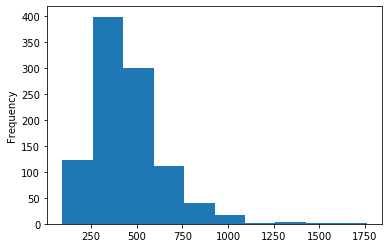

In [13]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
simulated_ending_prices.plot(kind="hist")

### Calculate Lower and Upper Bounds of 95% Confidence Interval for Simulated Ending Stock Prices of AAPL

In [14]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices.quantile(q=[0.025, 0.975])
confidence_interval

0.025    188.831799
0.975    914.759341
Name: 252, dtype: float64

### Plot the Probability Distribution and 95% Confidence Interval of Simulated Ending Prices 

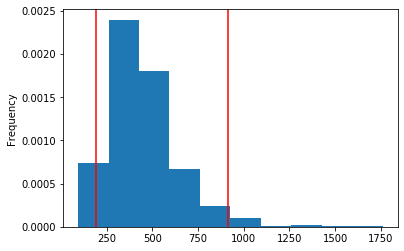

In [15]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
simulated_ending_prices.plot(kind="hist", density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color="r")
plt.axvline(confidence_interval.iloc[1], color="r")

### Calculate 95% Confidence Interval of An Initial Investment of 10,000 in AAPL over the Next 252 Trading Days

In [16]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - aapl_last_price) / aapl_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - aapl_last_price) / aapl_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in AAPL"
      f" over the next 252 trading days will end within in the range of"
      f" ${ending_investment_lower_bound} and ${ending_investment_upper_bound}")

There is a 95% chance that an initial investment of $10,000 in AAPL over the next 252 trading days will end within in the range of $6441.034173798742 and $31202.351580959134
